In [1]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q

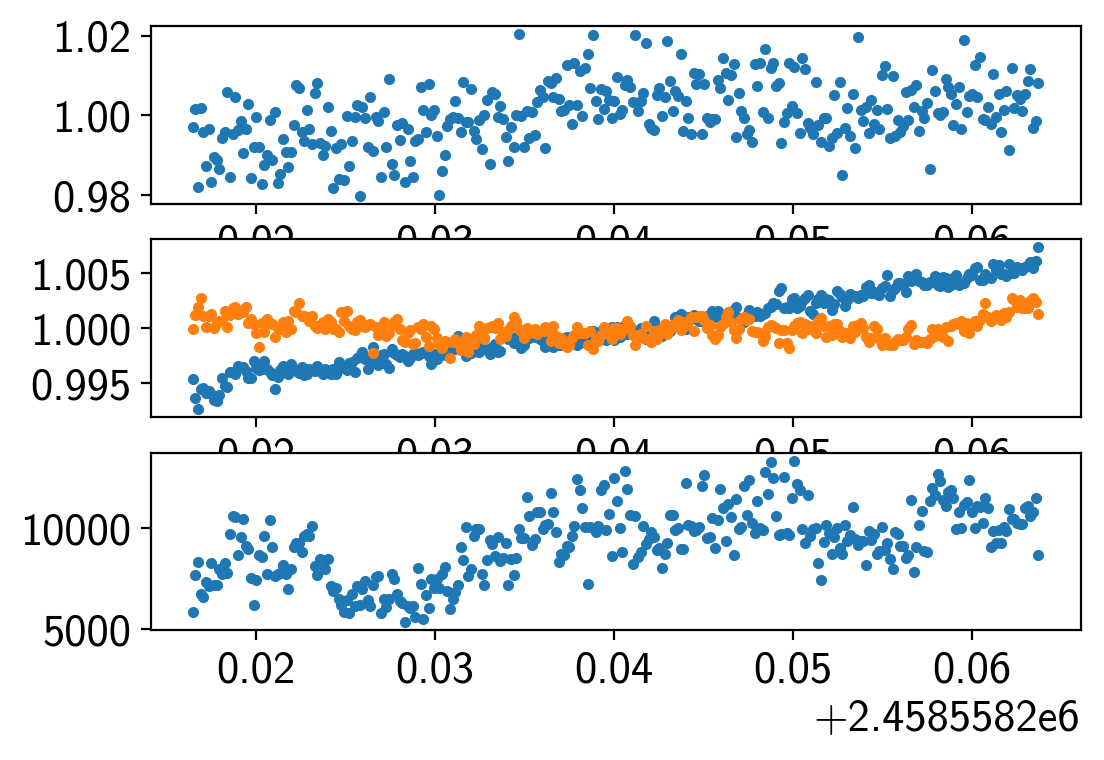

In [3]:
fp = '../data/20190315-TNT-EPIC211772348-i.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

0


<Container object of 3 artists>

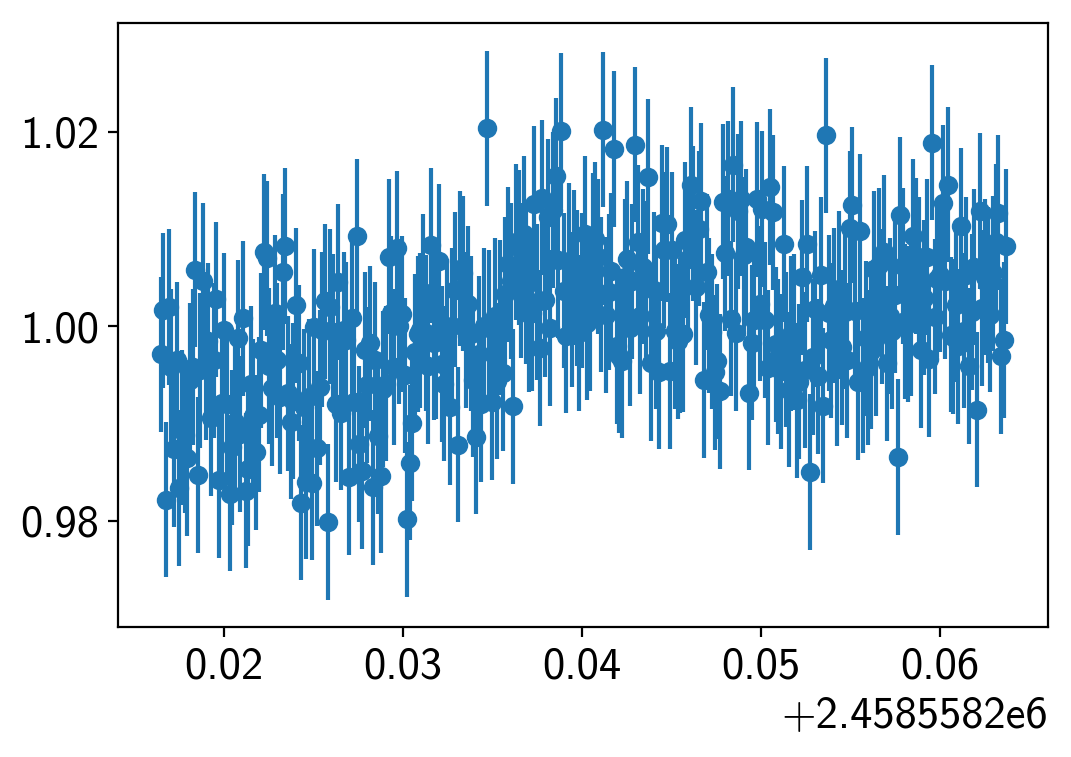

In [4]:
aux = np.c_[np.ones_like(time), time-time.min(), (time-time.min())**2, cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
# aux = np.c_[np.ones_like(time), time-time.min(), cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]

idx = mad_outliers(flux)
print(idx.sum())

time, flux, aux = time[~idx], flux[~idx], aux[~idx]
unc = flux.std()

pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [5]:
# bin the data
##############

# fp = 'TOI-136_irsf_181007_j.csv'
# df = pd.read_csv(fp)

# idx = mad_outliers(df['flux'].values)
# print('omitting {} outliers'.format(idx.sum()))
# df = df[~idx]

# binsize_min = 5
# binsize = binsize_min / (60 * 24)
# print(np.diff(df['BJD_TDB']).mean()*86400)
# bins = np.arange(df['BJD_TDB'].min(), df['BJD_TDB'].max(), binsize)
# groups = df.groupby(np.digitize(df['BJD_TDB'], bins))
# df_binned = groups.mean()
# df = df_binned.copy()

# aux = df['airmass sky dx dy fwhm peak'.split()].values
# time, flux, unc = df['BJD_TDB flux err'.split()].values.T
# pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [10]:
band = 'i*'

planets = { '211772348.01': { 'per': 0.651080, #0.5209,
                           'rprs': 0.11,
                           't0': 2458253.493040, #2458252.00403482,
                           't14': 0.076402}}

star = { 'feh': [0.0, 0.2],
            'logg': [4.5, 0.5],
            'rad': [0.84, 0.1],
            'teff': [5485, 200]}

teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]

ldp = limbdark.claret(band, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
u1, u2 = ldp[0], ldp[2]
q1, q2 = u_to_q(u1, u2)

# logg = map_float(star['logg'])
# rad = map_float(star['rad'])
# n = 10000
# rad_s = rad[0] + np.random.randn(n) * rad[1]
# logg_s = logg[0] + np.random.randn(n) * logg[1]
# rho_s = rho(logg_s, rad_s)
# rhop = rho_s.mean(), rho_s.std()

# priors = dict(ld=ldp, rho=rhop)

pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

while t0 < time.min():
    t0 += per
    
t0p = t0, 0.000830
perp = per, 0.000018
t14p = t14, 0.004506
priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p)
# priors = None

init_params = get_init_params(per, t0, t14, rprs, b=0.5, q1=q1, q2=q2)
init_params['priors'] = priors
init_params['ls'] = np.log(flux.std())
pp.pprint(init_params)

{ 'b': 0.5,
  'k': 0.11,
  'ls': -4.829973211529157,
  'p': 0.65108,
  'priors': { 'ld': ( 0.3561,
                      0.03892319995363177,
                      0.24600000000000002,
                      0.025448058602398335),
              'per': (0.65108, 1.8e-05),
              't0': (2458558.8495601006, 0.00083),
              't14': (0.076402, 0.004506)},
  'q1': 0.3625244100000001,
  'q2': 0.2957149975087195,
  'r': 1.41,
  't0': 2458558.8495601006,
  't14': 0.076402}


In [11]:
# fit = TransitFit(init_params, pl_name, time, flux, unc=unc, aux=aux)
fit = TransitFit(init_params, pl_name, time, flux, aux=aux)

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


In [12]:
fit.fit_map()

Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4586e+06 +/- 0        (0.00%) (init= 2458559)
    p:    0.65108 (fixed)
    k:    0.11 (fixed)
    r:    1.41 (fixed)
    b:    0.64347934 +/- 0        (0.00%) (init= 0.5)
    q1:   0.3625244 (fixed)
    q2:   0.295715 (fixed)
    ls:  -4.829973 (fixed)
    c0:   0.02828475 +/- 0        (0.00%) (init= 0)
    c1:  -0.18633014 +/- 0        (0.00%) (init= 0)
    c2:   2.36544159 +/- 0        (0.00%) (init= 0)
    c3:  -0.28224718 +/- 0        (0.00%) (init= 0)
    c4:   0.25661711 +/- 0        (0.00%) (init= 0)
    c5:   0.00435192 +/- 0        (0.00%) (init= 0)
None
Transit depth: 12100 [ppm]
Transit duration: 1.47 [h]
Log-probability: 1116.1821166712894
True
[[Variables]]
    t0:   2458559 (fixed)
    p:    0.65108 (fixed)
    k:    0.11 (fixed)
    r:    1.41 (fixed)
    b:    0.00109794 (init= 0.6434793)
    q1:   0.3625244 (fixed)
    q2:   0.295715 (fixed)
    ls:  -4.99041489 (init=-4.829973)
    c0:   0.01918136 (i

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


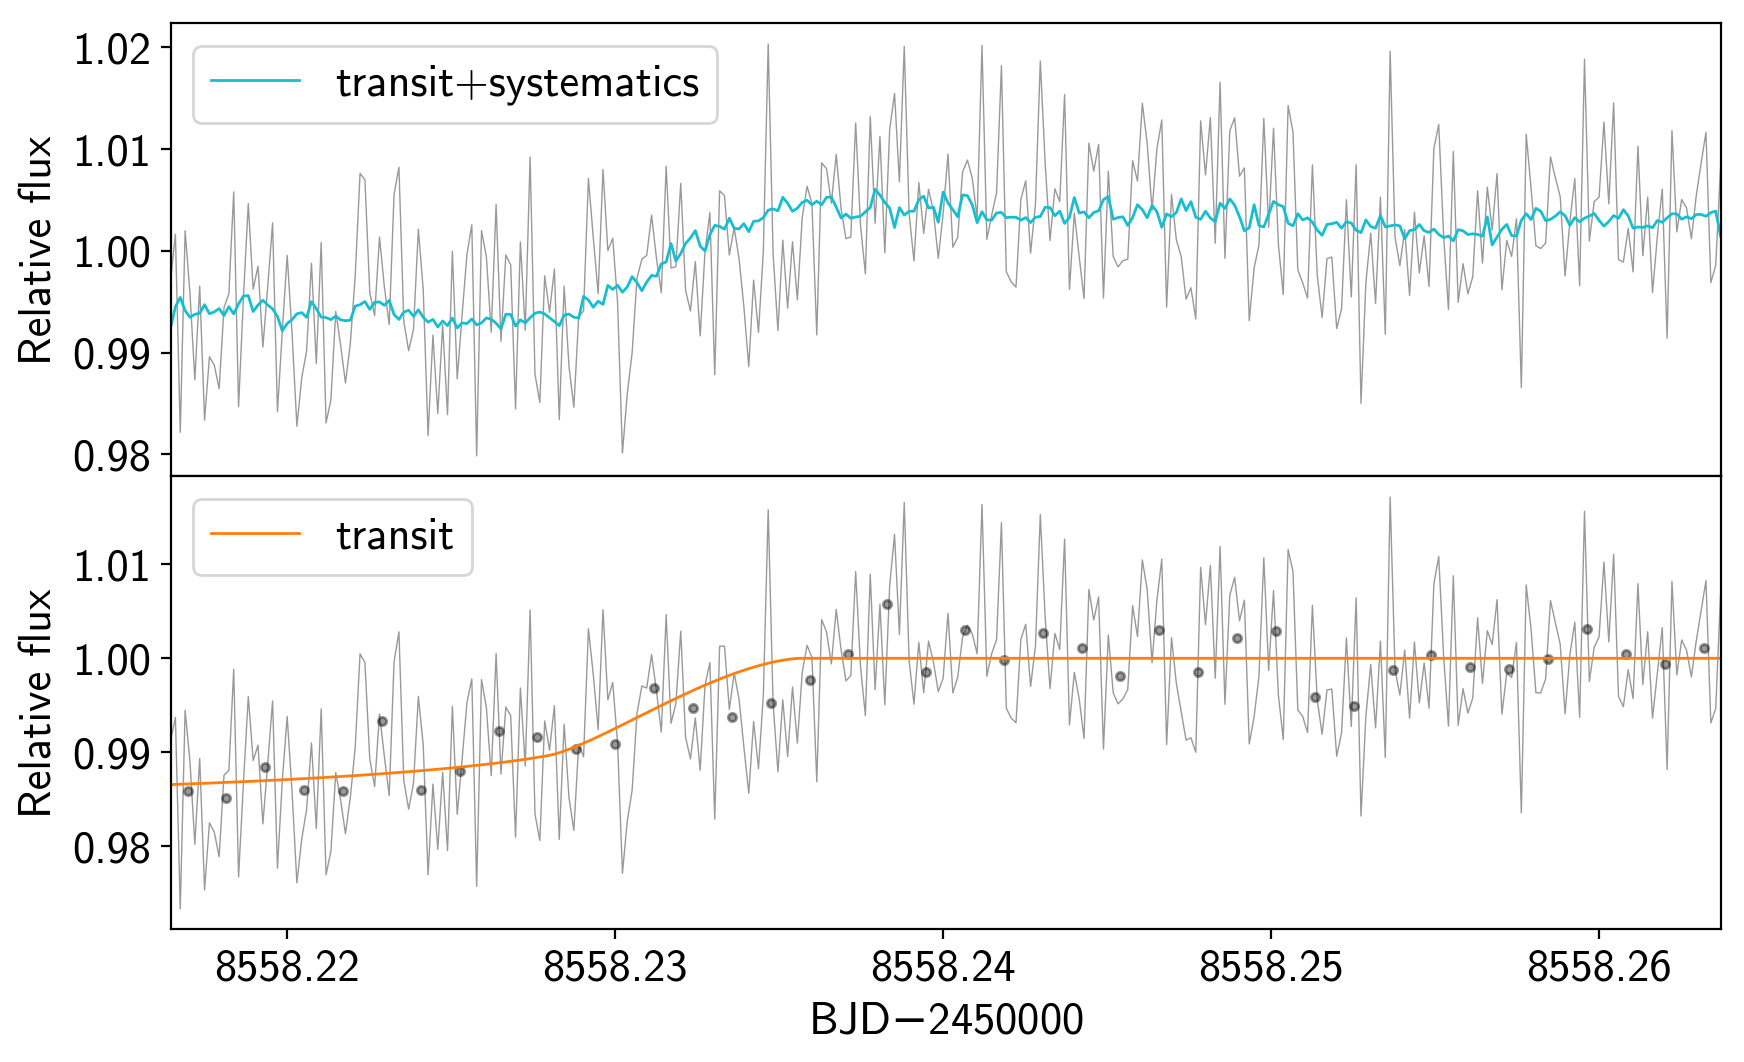

In [13]:
fit.plot_map()

In [14]:
# fit.fit_mcmc(two_stage=True)
fit.fit_mcmc(two_stage=True, steps=2000, nproc=4)

Running stage 1 MCMC (250 steps)...
Running production MCMC for 2000 steps...


../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/model.py:72: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t14, loc=t14p[0], scale=t14p[1]))
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))
../transitfit/util.py:72: RuntimeWarning: invalid value encountered in arcsin
  return (p / np.pi) * np.arcsin( alpha / np.sin(np.deg2rad(i)) / a )
../transitfit/model.py:72: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(t14, loc=t14p[0], scale=t14p[1]))
../transitfit/util.py:72: RuntimeWarning: invalid value encountered in arcsin
  return (p / np.pi) * np.arcsin( alpha / np.sin(np.deg2rad(i)) / a )
../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arc

[[Variables]]
    t0:   2.4586e+06 +/- 0.000877 (0.00%) (init= 2458559)
    p:    0.65107942 +/- 1.97e-05 (0.00%) (init= 0.65108)
    k:    0.10132212 +/- 0.021045 (20.77%) (init= 0.11)
    r:    1.13321649 +/- 0.261999 (23.12%) (init= 1.41)
    b:    0.12507187 +/- 0.226597 (181.17%) (init= 0.001097947)
    q1:   0.36763556 +/- 0.056088 (15.26%) (init= 0.3625244)
    q2:   0.29640449 +/- 0.018041 (6.09%) (init= 0.295715)
    ls:  -4.98751107 +/- 0.039158 (0.79%) (init=-4.990415)
    c0:   0.02598765 +/- 0.696601 (2680.51%) (init= 0.01918136)
    c1:  -0.10051956 +/- 0.334275 (332.55%) (init=-0.1871411)
    c2:   1.38520230 +/- 4.366804 (315.25%) (init= 2.851161)
    c3:  -0.33765031 +/- 0.560188 (165.91%) (init=-0.3352022)
    c4:   0.27661266 +/- 0.405791 (146.70%) (init= 0.3169186)
    c5:   0.00577671 +/- 0.003165 (54.80%) (init= 0.005453164)
None
FIT_MCMC elapsed time: 130 sec


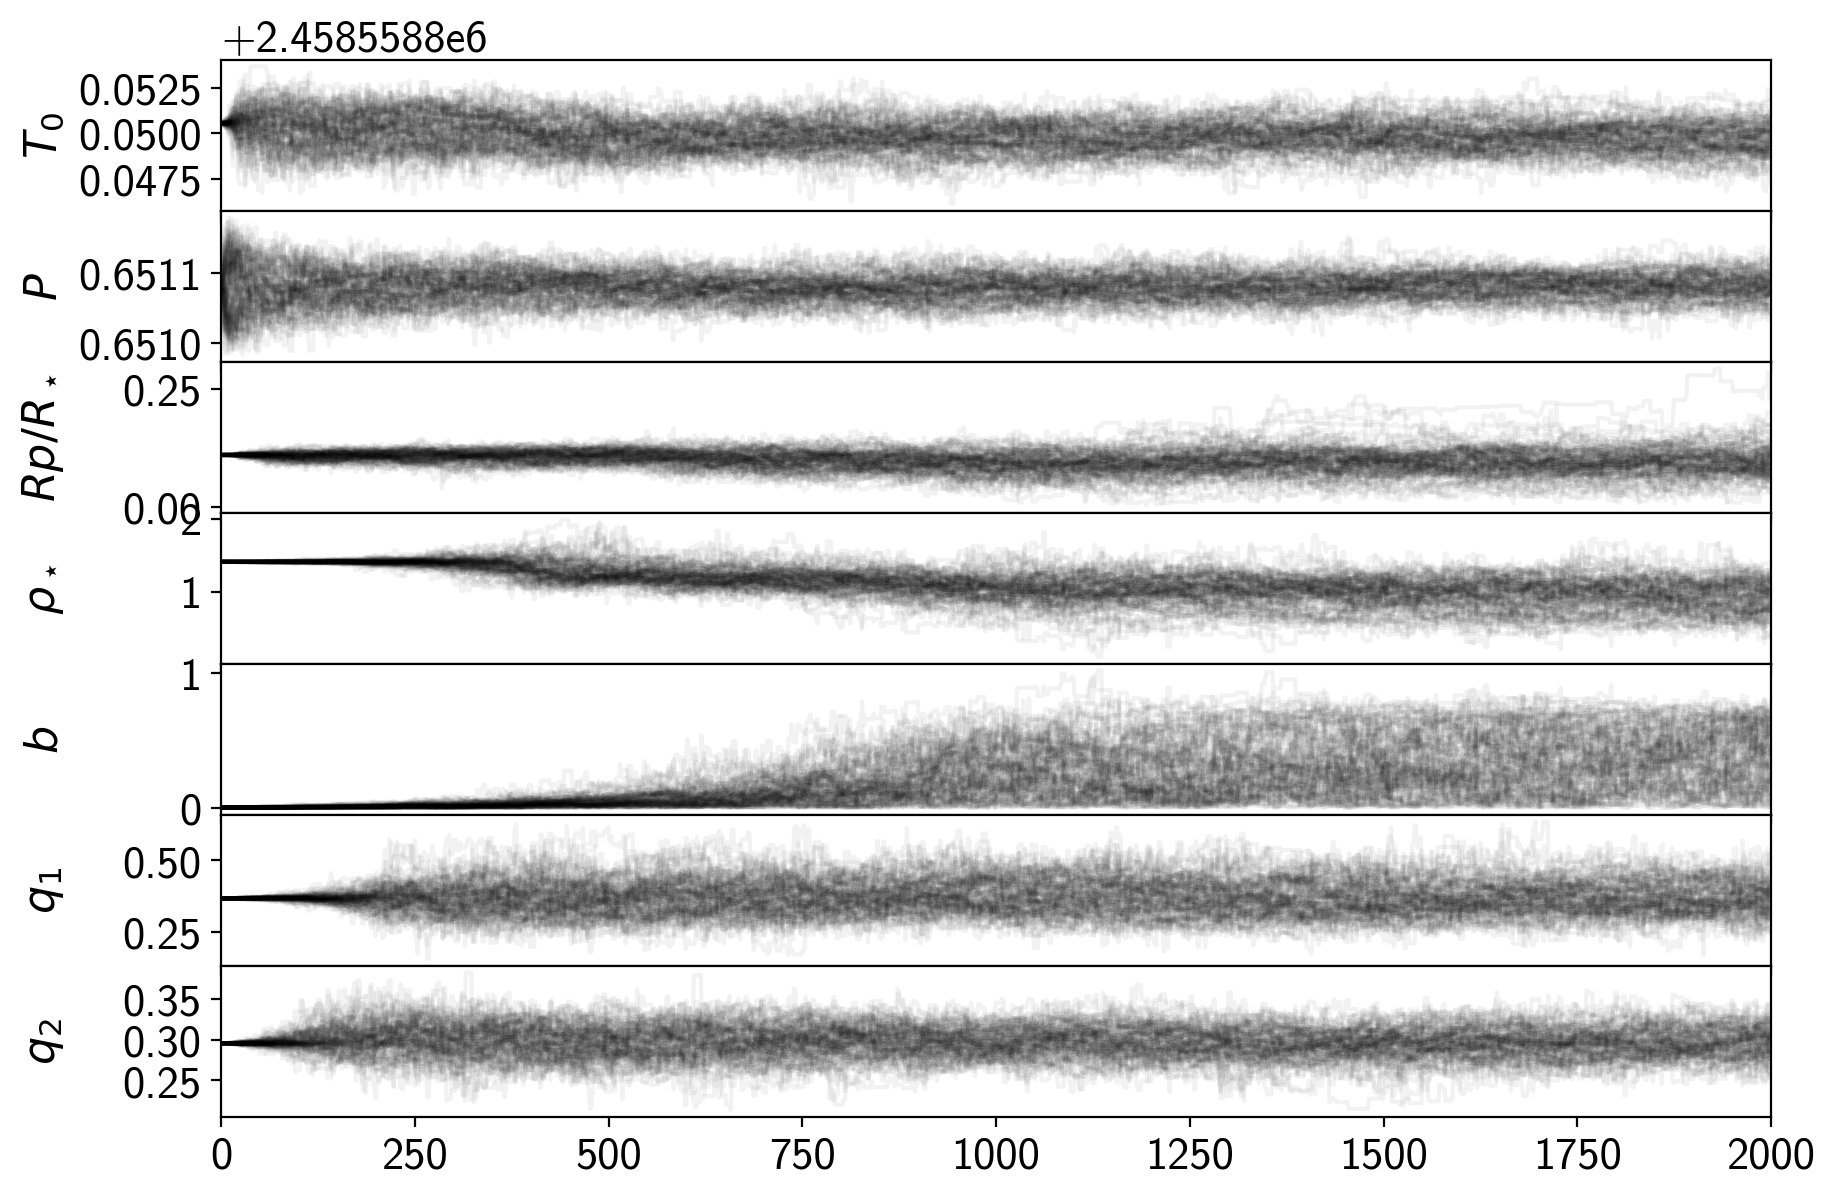

In [15]:
fit.plot_trace()

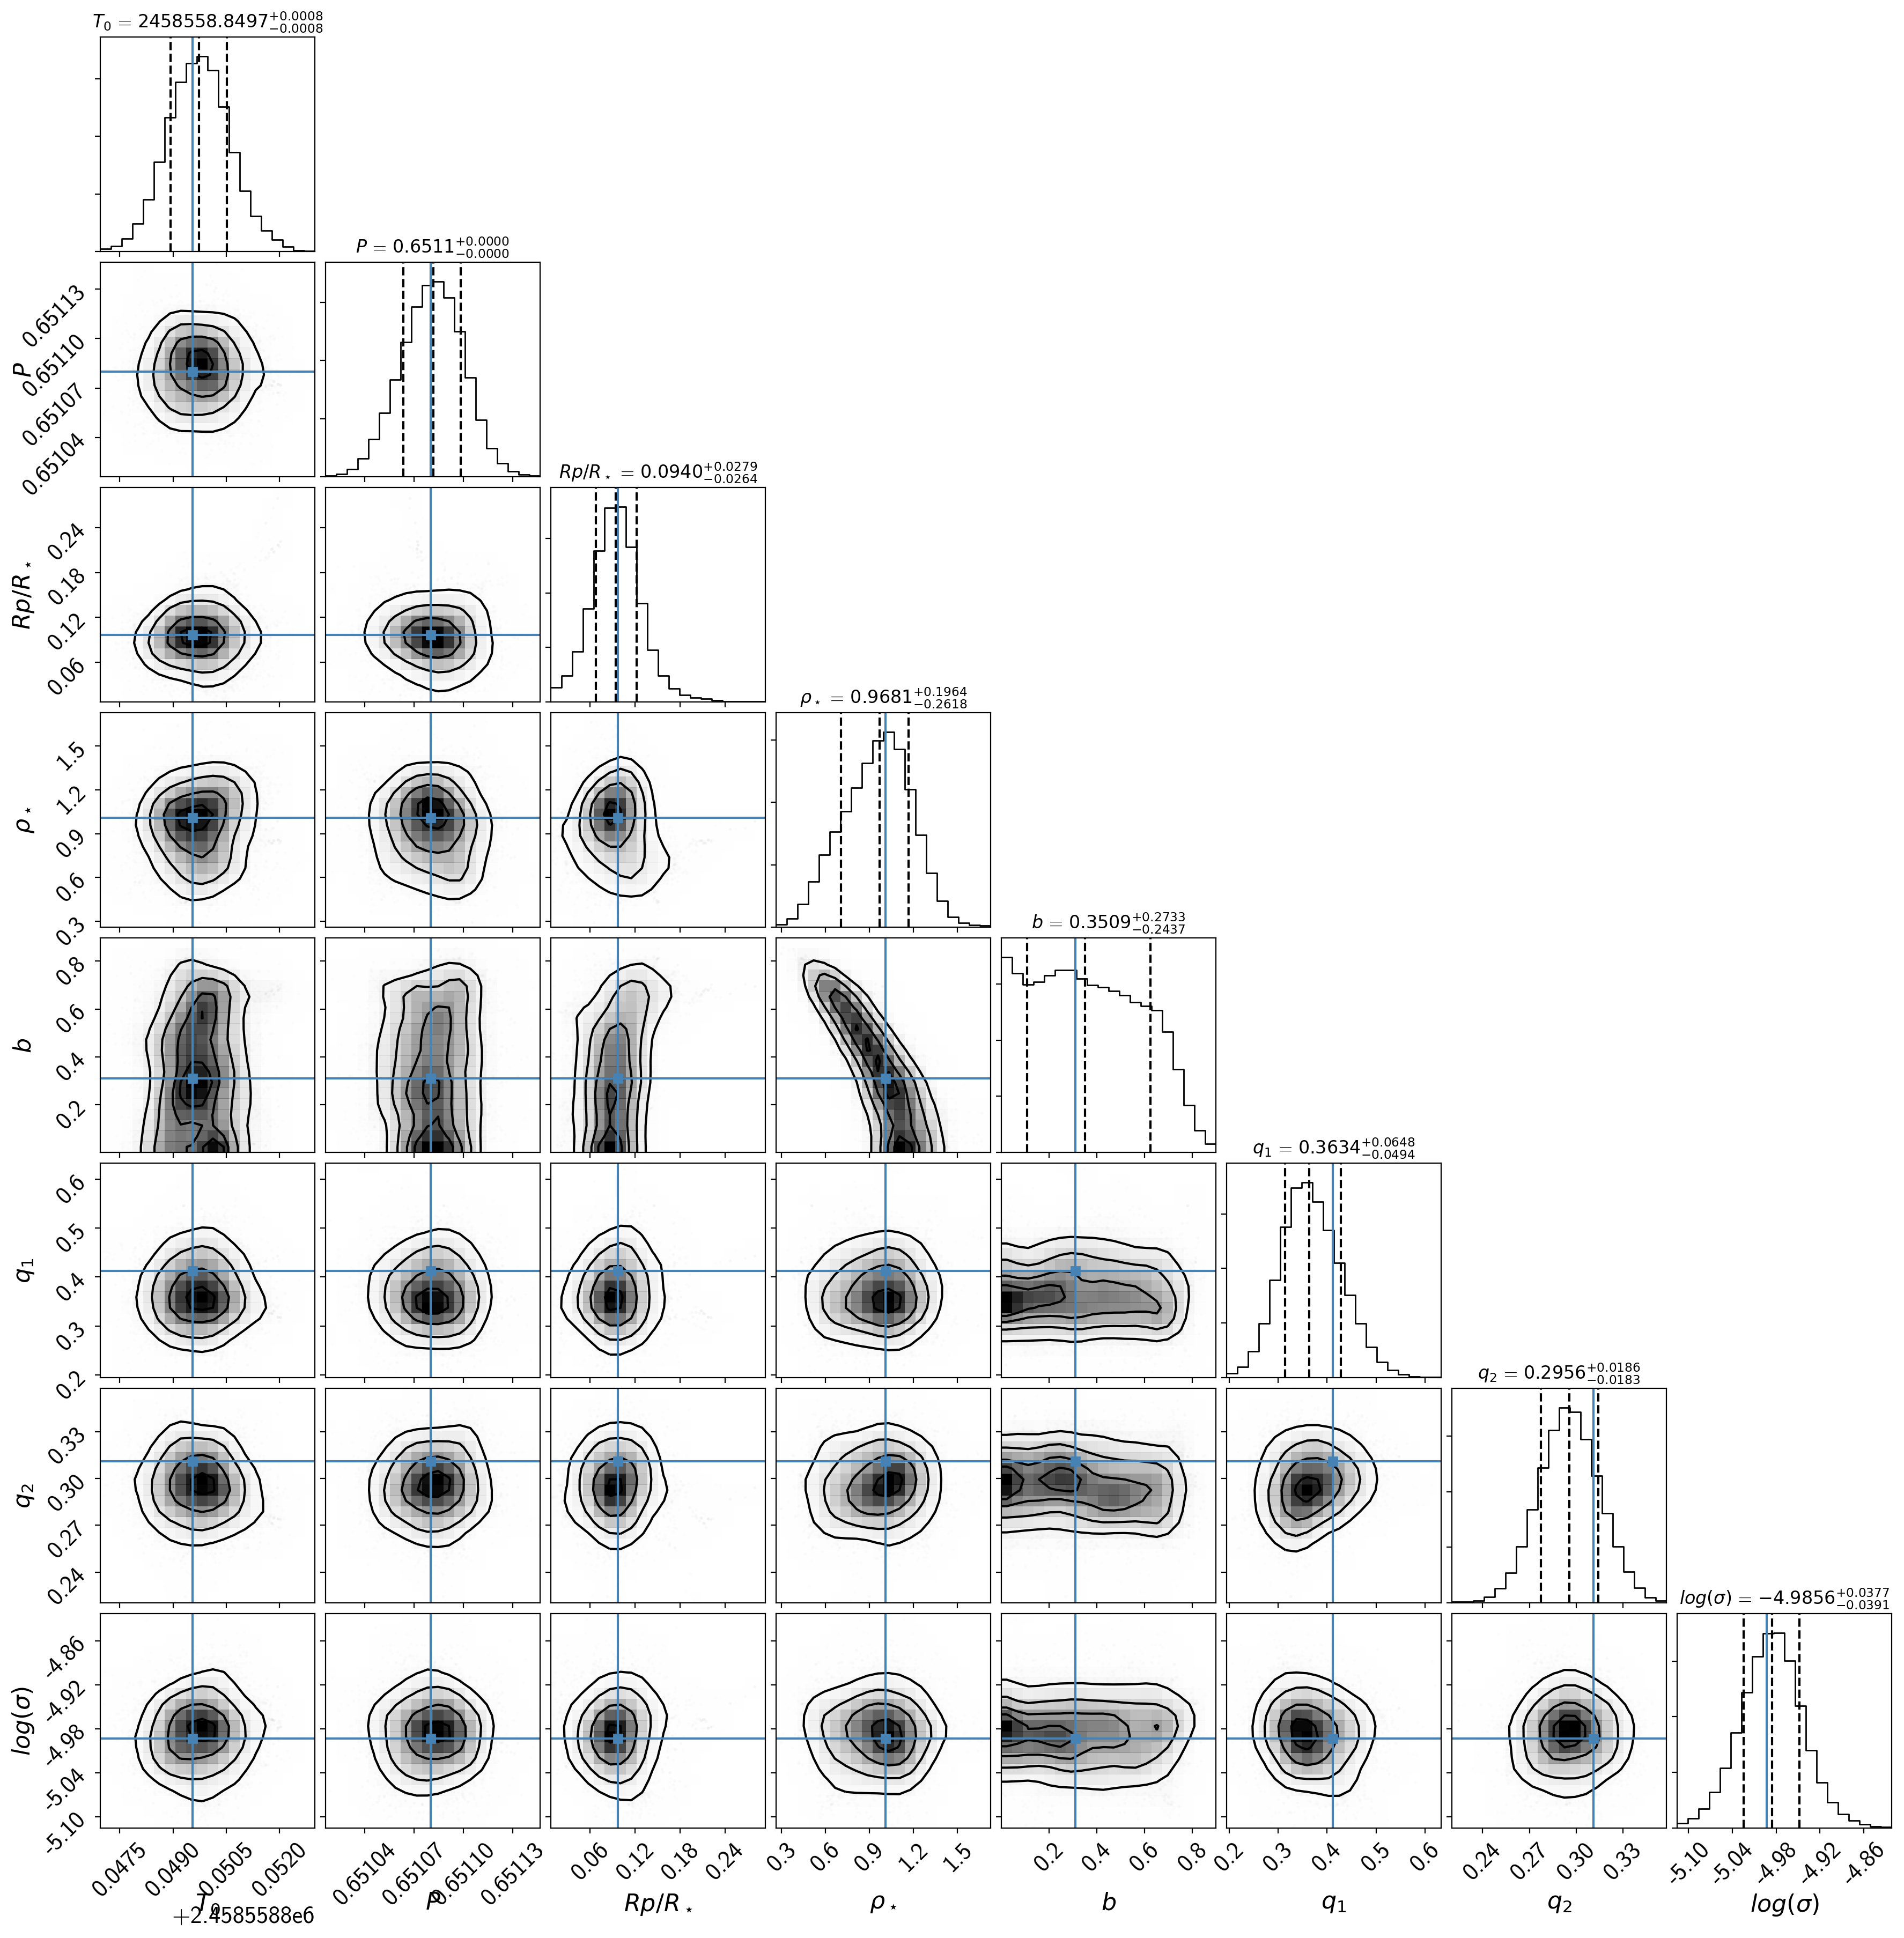

In [16]:
fit.burn_thin(burn=1500, thin=10)
fit.plot_corner()

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


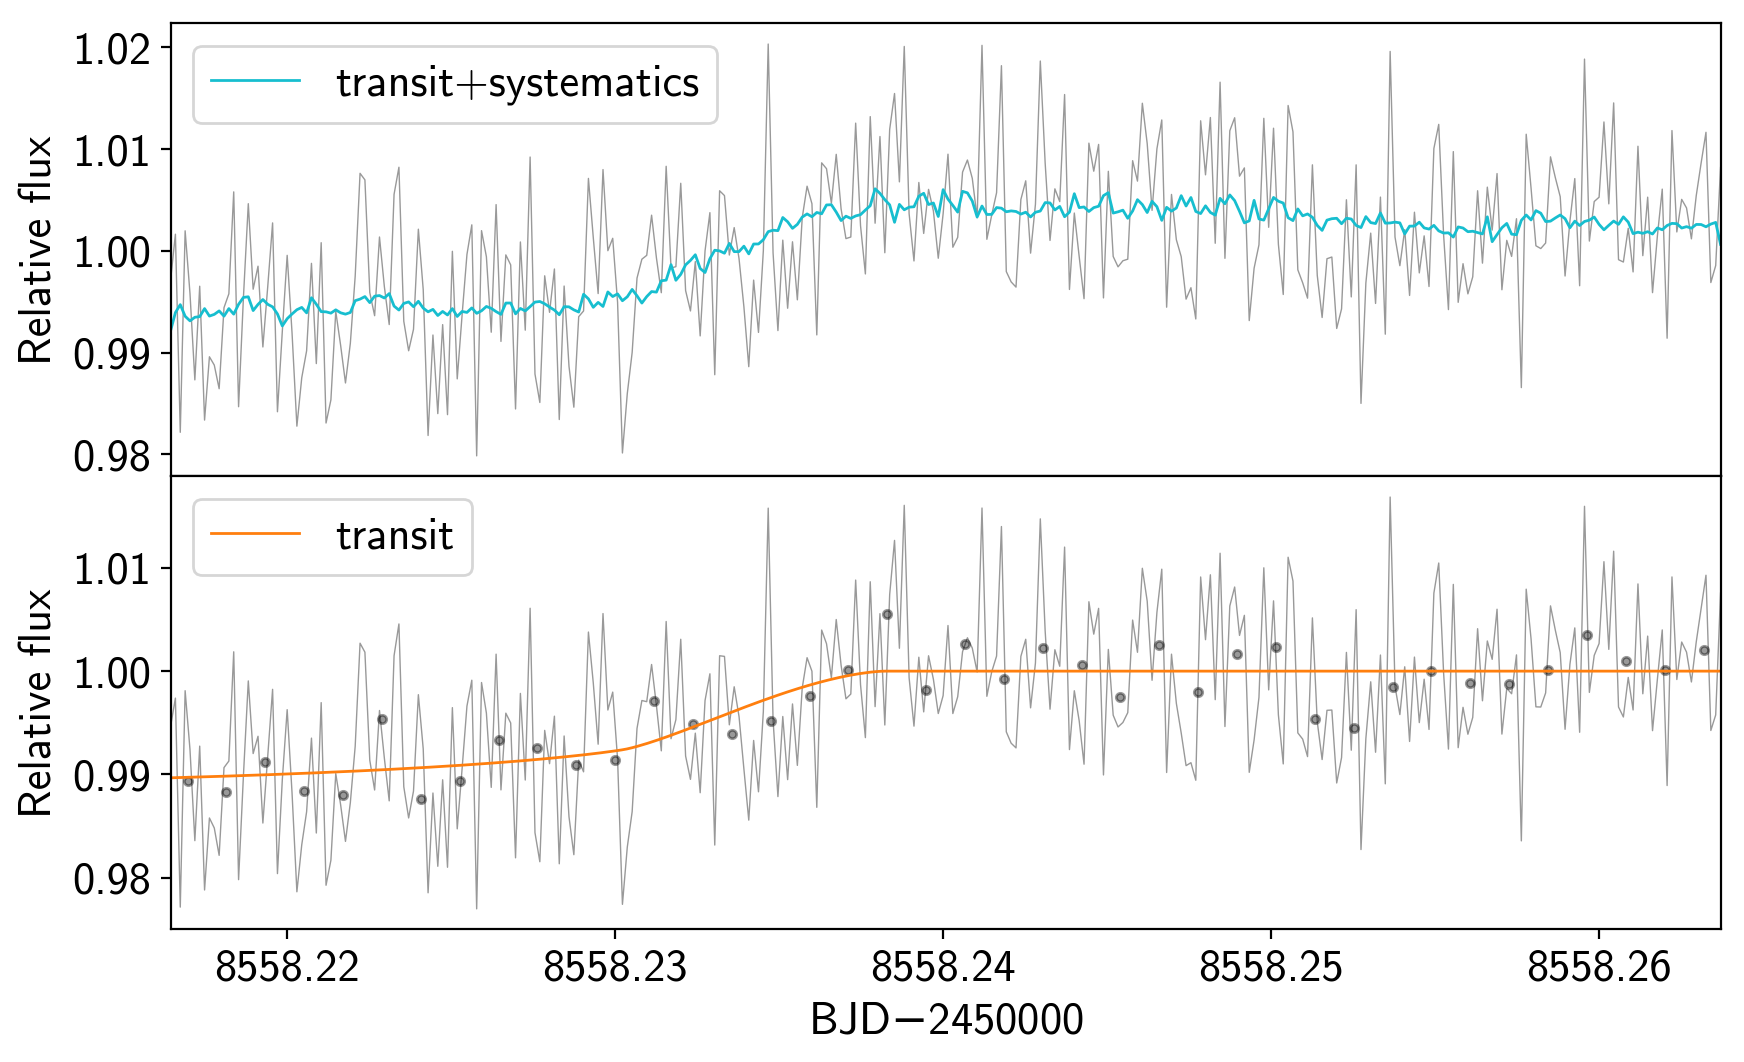

In [17]:
fit.plot_map()

../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


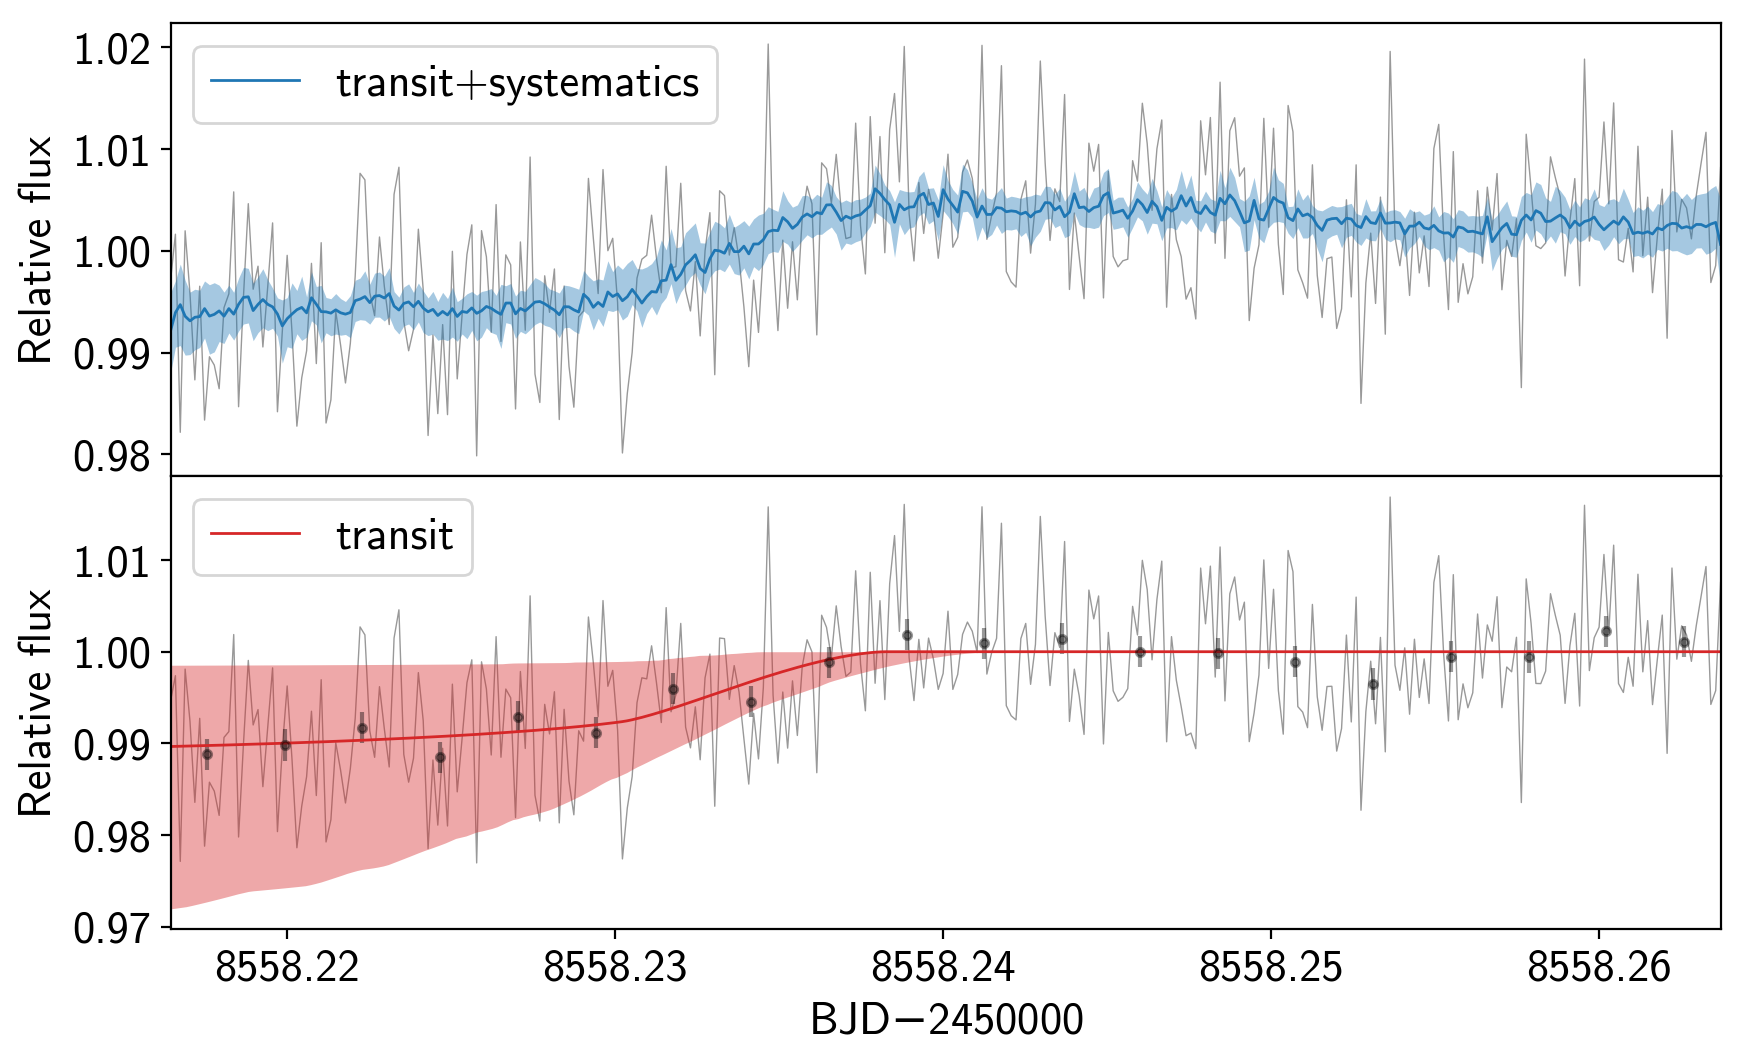

In [19]:
fig, axs = pl.subplots(2, 1, figsize=(10,6), sharex=True, sharey=False)
fit.plot_mcmc(binsize=16, c1='C0', c2='C3', axs=axs)
# pl.setp(axs[1], ylim=(0.85,1.05))

In [20]:
fit.get_df(*star['rad']).describe()

../transitfit/util.py:79: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt( (1 - k)**2 - b**2 )


t0            p            k            r            b  \
count  5.000000e+03  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2.458559e+06     0.651081     0.095486     0.949878     0.362664   
std    8.210442e-04     0.000018     0.031554     0.220203     0.219974   
min    2.458559e+06     0.651016     0.007411     0.262093     0.000208   
25%    2.458559e+06     0.651069     0.076567     0.798449     0.176195   
50%    2.458559e+06     0.651082     0.094015     0.968052     0.350917   
75%    2.458559e+06     0.651093     0.112829     1.105995     0.543676   
max    2.458559e+06     0.651146     0.293673     1.726115     0.897777   

                q1           q2           ls           c0           c1  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.368916     0.295653    -4.986016     0.053310     0.060715   
std       0.057689     0.018273     0.040114     0.880702     0.516858   
min       0.195016     0.220338    -5.115210    -3.538733    -3.674024   
25%       0.328698     0.283440    -5.012418    -0.549607    -0.187453   
50%       0.363381     0.295575    -4.985630     0.053764     0.116534   
75%       0.406021     0.307880    -4.960793     0.640256     0.391279   
max       0.632680     0.357807    -4.822194     3.079491     1.356598   

          ...                c4           c5        rstar       pl_rad  \
count     ...       5000.000000  5000.000000  5000.000000  5000.000000   
mean      ...          0.261347     0.006242     0.841804     8.766023   
std       ...          0.489639     0.002980     0.100410     3.093817   
min       ...         -1.408994    -0.007745     0.434804     0.513255   
25%       ...         -0.078260     0.004320     0.771300     6.839640   
50%       ...          0.291279     0.006129     0.843048     8.550183   
75%       ...          0.595856     0.008041     0.911665    10.457244   
max       ...          1.804210     0.017847     1.187200    29.466420   

                 a          inc          t14          t23        shape  \
count  5000.000000  5000.000000  5000.000000  4998.000000  4998.000000   
mean      2.753444    81.996007     0.078870     0.060540     0.769890   
std       0.224690     5.460942     0.003276     0.008071     0.110468   
min       1.804234    60.159015     0.064664     0.014353     0.170720   
25%       2.615540    77.986205     0.076750     0.057925     0.736352   
50%       2.788939    82.830589     0.078935     0.062114     0.797661   
75%       2.915535    86.566011     0.081132     0.065533     0.838941   
max       3.381945    89.996090     0.089910     0.078564     0.980721   

             max_k  
count  4998.000000  
mean      0.134995  
std       0.080371  
min       0.009733  
25%       0.087582  
50%       0.112557  
75%       0.151840  
max       0.708350  

[8 rows x 22 columns]